# Matrix Analysis 2022 - EE312

## Week 6 - Linear systems - Poisson equation
[LTS2](https://lts2.epfl.ch)

### Objectives
Solve the Poisson equation in the discrete domain using linear systems

Let $u,v \in \mathbb{R}^n$  represent a physical quantity $f$ and $g: \mathbb{R} \mapsto \mathbb{R}$ sampled at $n$ equi-spaced locations $x_i$, i.e $u_i = f(x_i)$, $v_i = g(x_i)$. 
Let us assume that the underlying continuous object satisfies the Poisson equation: $\frac{d^2}{dx^2} f (x)= g(x)$ with constraints $f(x_j) = y_j$ for a subset of $m$ locations $j \in \{i_1, \ldots i_m \}$. We will assume that all the $i_k$ are distincts.

1. Write down a matrix equation for the discrete version of $\frac{d^2}{dx^2} f (x)= g(x)$, using the finite-difference approximation of the derivative $\frac{d^2}{dx^2} f  = f(x_{k+1}) - 2f(x_k) +f(x_{k-1})$. For the boundary conditions we will make the assumption that $x_{-1}=x_0$ and $x_{n-1}=x_n$ (also referred to as Dirichlet boundary conditions)
   

If we use zero-padding instead of the constant extension this equations satisfy $Du = v$ with 
$D=\begin{pmatrix}
-2 & 1 & 0  & 0& ... & 0\\ 
1 & -2 & 1 & 0 &... &0\\
0 & 1 & -2 & 1 &... &0\\
& & & ... & & \\
0 & 0 & ... & 1 & -2 & 1\\
0 & 0 & ... & 0 & 1 & -2\\
\end{pmatrix}$

This is the laplacian matrix. 

$\mbox{rank }D = n$.

If we use a Dirichlet boundary condition, i.e. constant extension, we have $u_{-1}=u_0$ and $u_n = u_{n+1}$, therefore

$D=\begin{pmatrix}
-1 & 1 & 0  & 0& ... & 0\\ 
1 & -2 & 1 & 0 &... &0\\
0 & 1 & -2 & 1 &... &0\\
& & & ... & & \\
0 & 0 & ... & 1 & -2 & 1\\
0 & 0 & ... & 0 & 1 & -1\\
\end{pmatrix}$

In this case the rank is $n-1$ since the sum of rows/columns is 0 and if we remove one row/column they become linearly independent.

In [2]:
import numpy as np
def lapl_matrix(N):
    O = np.ones(N-1)
    D = -2*np.eye(N) + np.diag(O, -1) + np.diag(O, 1)
    D[0,0] = -1
    D[N-1, N-1] = -1
    return D

In [3]:
lapl_matrix(5)

array([[-1.,  1.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  1., -1.]])

In [4]:
np.linalg.matrix_rank(lapl_matrix(8))

7

  ---
  
  
2. Write down a matrix equation for the discrete version of $f(x_j) = y_j$. What is the rank of the corresponding matrix ?

This operation can be represented by a matrix $B\in\mathbb{R}^{n\times m}$ where the coefficients $b_{kp} = \delta_{ki_p}$.
The rank of this matrix is $m$, under the assumption that all $i_k$ are distinct, since every row has a single non-zero value.

Using this matrix we can rewrite the condition $f(x_j) = y_j$ as $Bu=\begin{pmatrix}y_0\\ \vdots \\y_{m-1}\end{pmatrix}$
      

In [5]:
def b_matrix(N, idx):
    m = len(idx)
    B = np.zeros((m, N))
    for p in zip(range(m), idx):
        B[p[0], p[1]] = 1.
    return B

In [6]:
b_matrix(5, [1, 3])

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

  ---
  
3. Write down a matrix equation for the full problem. Discuss the rank of the matrix and deduce a way to numerically solve the linear system. Implement it.

Let us use the matrix $C=\begin{pmatrix}D\\B\end{pmatrix}$.

The following holds $Cu = z$, with $z=\begin{pmatrix}v_0\\v_1\\...\\v_{n-1}\\y_0\\y_1\\...\\y_{m-1}\end{pmatrix}$.

Let us suppose there exist non zero $\alpha_i$ s.t.

$\sum_{i=0}^{n-1} \alpha_i C_i = 0$, where $C_i$ is the $i$-th column of $C$.

Looking at the bottom part of $C$, we must have $\alpha_i=0, i\in\{i_1,...,i_m\}$. The $\alpha_i$ are can only be non-zero when the lower part of the vector only has 0s. Given a subset of columns of $D$ will have at least one row with a single non zero coefficient  making the associated $\alpha_i = 0$, which then propagates to the rest (since columns have disjoint support), the rank of $C$ is $n$.

We can get the solution using $C^+$.

In [7]:
def c_matrix(D, B):
    sd = D.shape
    sb = B. shape
    C = np.zeros((sd[0]+sb[0], sd[1]))
    C[:sd[0], :] = D
    C[sd[0]:, :] = B
    return C

In [9]:
C=c_matrix(lapl_matrix(10), b_matrix(10, [2, 4, 6, 8]))

The rank of $C$ is $n$, the columns of $C$ are independent, therefore the matrix is 1-1. We can use the left pseudo inverse

$C^+=(C^TC)^{-1}C^T$

In [10]:
Cinv = np.linalg.inv(C.T@C)@C.T

We achieve the same result whether we use the explicit formula or Numpy's `pinv`.

---

4. Let us now consider the solutions of the particular case $g(x) = 0, \forall x\in\mathbb{R}$. What are the analytical solutions that would solve Poisson equation ?

The analytical solutions are linear functions, i.e. $f(x)=ax+b$.

In [11]:
def solve_poisson(N, v, idx_list, u): 
    D = lapl_matrix(N)
    B = b_matrix(N, idx_list)
    C = c_matrix(D, B)
    z = np.zeros(C.shape[0])
    z[:N] = v
    for p in zip(range(len(u)), u):
        z[N+p[0]] = p[1]
    Cinv = np.linalg.pinv(C)
    #or 
    # Cinv = np.linalg.inv(C.T@C)@C.T
    return Cinv@z

In [12]:
# pick values on a linear function
sol = solve_poisson(50, np.zeros(50), [10, 20, 30, 40], [10, 20, 30, 40])

In [14]:
import matplotlib.pyplot as plt

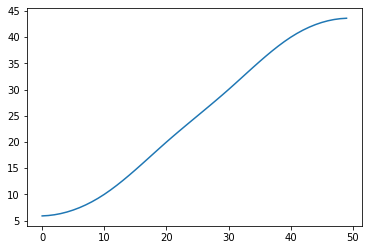

In [15]:
plt.plot(sol)

In [16]:
print(sol[10], sol[20], sol[30], sol[40])

10.009860690220727 19.985272670831275 30.01543978679425 39.989426852153734


We obtain a solution that is linear except near it boundaries. The aspect of the solution near the boundaries is due to the Dirichlet conditions we impose (i.e. solution should be constant outside the interval displayed). The values we had set as constraints are matched closely.

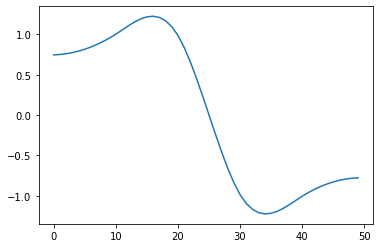

In [28]:
sol2 = solve_poisson(50, np.zeros(50), [10, 20, 30, 40], [1, 1, -1, -1])
plt.plot(sol2)

If we deliberately choose $f$ to be outside of the solution space, we obtain a poor approximation and our constraints are not met (which is expected).

---

5. Let us now consider the application of the Poisson equation to electrostatic. Knowing a distribution of electric charges, we can solve it to compute the electric potential. The distribution of electric charges will be very simple, consisting of two punctual charges


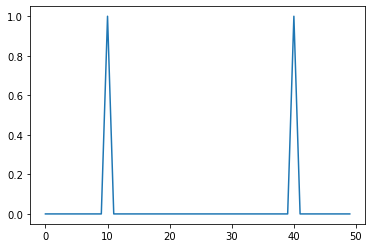

In [29]:
N = 50
v3 = np.zeros(N)
v3[10] = 1
v3[40] = 1
plt.plot(v3)

The analytical solution is a piecewise linear solution. Integrating once the 2-peaked will lead to picewise constant function, and piecewise linear if we integrate twice. 

If you use the constraints we impose for the numerical example you can compute the theoretical solution of the problem satisfying the constraints (that was not asked in the question so the above answer was sufficient). If you impose the solution to be constant between 10 and 40, it means its derivative is 0 in this interval. Below 10 the derivative is then -1 and above 40 the derivative is 1. 

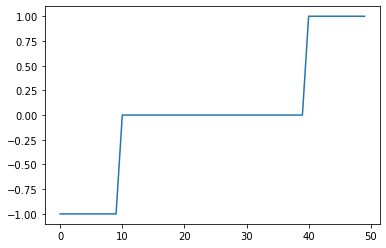

In [30]:
d=np.zeros(50)
d[:10]=-1
d[40:]=1
plt.plot(d)

If we solve $-x+a = 1$ for $x=10$ and $x+b=1$ for $x = 40$, the analytical solution that satisfies the constraint is:
- $f(x) = -x+11, x<10$
- $f(x) = 1, 10\le x\le 40$
- $f(x) = x - 39, x>40$

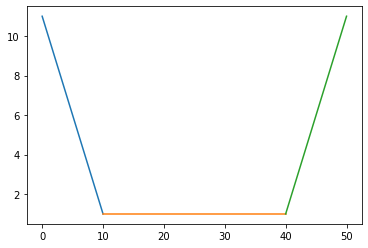

In [22]:
x1 = np.arange(0, 11)
x2 = np.arange(10, 41)
x3 = np.arange(40, 51)
plt.plot(x1, -x1+11)
plt.plot(x2, np.ones(x2.shape))
plt.plot(x3, x3-39)

In [34]:
v3.shape

(50,)

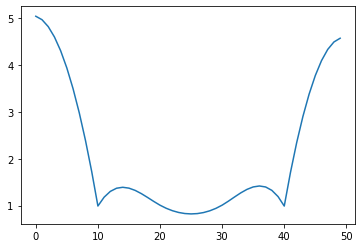

In [35]:
sol3 = solve_poisson(50, v3, [10, 20, 30, 40], [1, 1, 1, 1])
plt.plot(sol3)

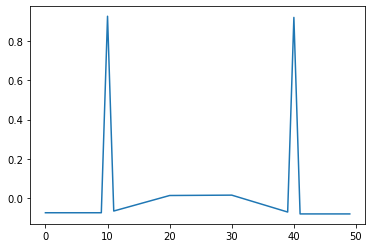

In [37]:
plt.plot(lapl_matrix(50)@sol3[:50]) # check the 2nd derivative of the solution computed

We can see the solution computed is acceptable as its second derivative matches the original distribution (it is not fully constant between the peaks but close enough). The Dirichlet boundary conditions are once again interfering at $x=0$ and $x=50$, and the derivative not being continuous also has an impact on the constant part.